<a href="https://colab.research.google.com/github/qubvel/transformers-notebooks/blob/main/notebooks/ViTPose_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Estimation with ViTPose

Pose estimation is a computer vision task focused on detecting and tracking human body keypoints (such as joints and limbs) from images or videos. It has wide-ranging applications, including fitness tracking, animation, sports analysis, augmented reality, and healthcare.

In this notebook, we’ll explore **ViTPose**, a state-of-the-art model for pose estimation based on Vision Transformers (ViT). ViTPose is a **top-down keypoint detection model**, meaning it first detects the bounding boxes of human subjects in an image (using an external object detection model) and then estimates the keypoints for each detected person individually. This top-down approach enables ViTPose to focus on each individual, resulting in high precision for pose estimation tasks, even in crowded scenes.

ViTPose leverages the self-attention mechanism of Vision Transformers to capture both global and local dependencies in images. Its transformer-based architecture is particularly well-suited for learning complex spatial relationships between keypoints, making it a highly effective and robust solution for pose estimation. ViTPose achieves impressive accuracy and generalizability across different use cases.

This Colab notebook will guide you through:  
1. **Detecting humans** using pre-trained RT-DETR model from Transformers.  
2. **Performing inference** with VitPose on images to detect human poses.  
3. **Visualizing the results** with detected keypoints overlaid on input images.  

By the end of this notebook, you'll have a clear understanding of how to use ViTPose for pose estimation tasks and integrate it into your own projects. Let's get started!

In [ ]:
# install the latest version
!pip install -U -q git+https://github.com/huggingface/transformers
!pip install -q supervision

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
import torch
import requests
import numpy as np

from PIL import Image

from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)

device = "cuda" if torch.cuda.is_available() else "cpu"

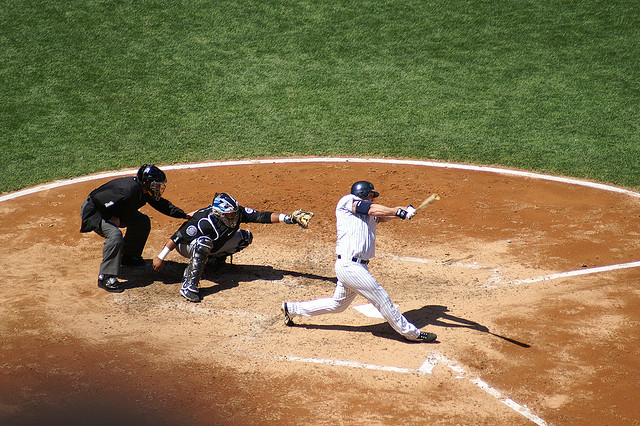

In [ ]:
url = "https://s3.us-east-1.amazonaws.com/images.cocodataset.org/train2017/000000538414.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

## Run Pose Estimation

### Stage 1. Run Object Detector

Alright, after installing the dependencies and loading the image, let's run the RT-DETR (Real-Time Detection Transformer) model from Transformers to detect human bounding boxes. RT-DETR is an object detection model designed for real-time performance. Built on the transformer architecture, it eliminates the need for complex post-processing like non-maximum suppression by directly predicting object boxes and class labels. This makes it both efficient and highly accurate, even in challenging scenarios. We'll use it here to detect human bounding boxes as a pre-processing step for the ViTPose model.

In [ ]:
# You can choose detector by your choice
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device)

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes_xyxy = result["boxes"][result["labels"] == 0]
person_boxes_xyxy = person_boxes_xyxy.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes = person_boxes_xyxy.copy()
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]
person_boxes

array([[281.3606 , 180.08398, 156.88568, 162.73584],
       [152.26488, 191.88069, 161.49892, 110.61919],
       [ 78.84734, 163.79568, 113.77029, 128.98795]], dtype=float32)

### Stage 2. Run Keypoint detection with ViTPose

In [ ]:
image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple", device_map=device)

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

# for vitpose-plus-base checkpoint we should additionaly provide dataset_index
# to sepcify which MOE experts to use for inference
if model.config.backbone_config.num_experts > 1:
    dataset_index = torch.tensor([0] * len(inputs["pixel_values"]))
    dataset_index = dataset_index.to(inputs["pixel_values"].device)
    inputs["dataset_index"] = dataset_index

with torch.no_grad():
    outputs = model(**inputs)

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
image_pose_result = pose_results[0]  # results for first image

print(image_pose_result)

[{'keypoints': tensor([[371.2295, 198.4681],
        [371.3415, 194.7851],
        [369.4690, 194.6743],
        [362.7020, 193.7652],
        [361.1994, 193.2587],
        [365.1815, 209.2093],
        [345.5732, 200.9034],
        [380.4861, 215.0647],
        [371.2540, 208.0569],
        [399.9811, 211.8208],
        [398.4681, 210.6179],
        [355.2080, 265.4798],
        [348.7155, 264.8138],
        [338.4224, 303.1122],
        [381.7750, 298.7093],
        [294.0832, 307.5825],
        [410.6687, 331.7478]]), 'scores': tensor([0.8258, 0.8487, 0.8713, 0.6436, 0.8655, 0.6812, 0.9149, 0.7871, 0.8708,
        0.9028, 0.9831, 0.6868, 0.8758, 0.9720, 0.9276, 0.8785, 0.8684]), 'labels': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'bbox': tensor([359.8034, 261.4519, 359.7840, 261.7593])}, {'keypoints': tensor([[231.9524, 217.2004],
        [233.1600, 213.6772],
        [227.1441, 214.8745],
        [235.8453, 210.1427],
        [216.8557, 214.0974]

In [ ]:
# print results in more human-readable format
for i, person_pose in enumerate(image_pose_result):
    print(f"Person #{i}")
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"]
    ):
        keypoint_name = model.config.id2label[label.item()]
        x, y = keypoint
        print(f" - {keypoint_name}: x={x.item():.2f}, y={y.item():.2f}, score={score.item():.2f}")

Person #0
 - Nose: x=371.23, y=198.47, score=0.83
 - L_Eye: x=371.34, y=194.79, score=0.85
 - R_Eye: x=369.47, y=194.67, score=0.87
 - L_Ear: x=362.70, y=193.77, score=0.64
 - R_Ear: x=361.20, y=193.26, score=0.87
 - L_Shoulder: x=365.18, y=209.21, score=0.68
 - R_Shoulder: x=345.57, y=200.90, score=0.91
 - L_Elbow: x=380.49, y=215.06, score=0.79
 - R_Elbow: x=371.25, y=208.06, score=0.87
 - L_Wrist: x=399.98, y=211.82, score=0.90
 - R_Wrist: x=398.47, y=210.62, score=0.98
 - L_Hip: x=355.21, y=265.48, score=0.69
 - R_Hip: x=348.72, y=264.81, score=0.88
 - L_Knee: x=338.42, y=303.11, score=0.97
 - R_Knee: x=381.77, y=298.71, score=0.93
 - L_Ankle: x=294.08, y=307.58, score=0.88
 - R_Ankle: x=410.67, y=331.75, score=0.87
Person #1
 - Nose: x=231.95, y=217.20, score=0.98
 - L_Eye: x=233.16, y=213.68, score=0.94
 - R_Eye: x=227.14, y=214.87, score=0.99
 - L_Ear: x=235.85, y=210.14, score=0.85
 - R_Ear: x=216.86, y=214.10, score=0.99
 - L_Shoulder: x=237.96, y=213.91, score=0.95
 - R_Shoul

## Visualize results


To visualize the results, we'll use Supervision, a powerful library for annotating and rendering visual outputs in computer vision tasks. With Supervision, we can overlay detected bounding boxes from RT-DETR and keypoints from ViTPose directly on the input image, creating clear and intuitive visualizations. This helps us easily interpret the pose estimation results and validate the performance of the model. Let’s generate the visualizations to bring the predictions to life!

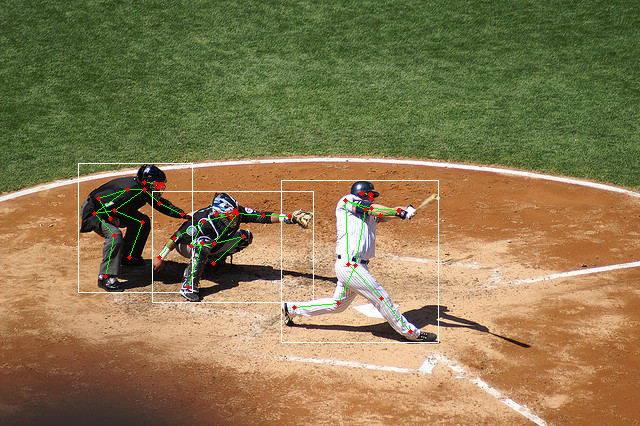

In [ ]:
import supervision as sv

# preprocess to torch tensor of shape (n_objects, n_keypoints, 2)
xy = [pose_result['keypoints'] for pose_result in image_pose_result]
xy = torch.stack(xy).cpu().numpy()

scores = [pose_result['scores'] for pose_result in image_pose_result]
scores = torch.stack(scores).cpu().numpy()

keypoints = sv.KeyPoints(xy=xy, confidence=scores)
detections = sv.Detections(xyxy=person_boxes_xyxy)

edge_annotator = sv.EdgeAnnotator(color=sv.Color.GREEN, thickness=1)
vertex_annotator = sv.VertexAnnotator(color=sv.Color.RED, radius=2)
bounding_box_annotator = sv.BoxAnnotator(
    color=sv.Color.WHITE, color_lookup=sv.ColorLookup.INDEX, thickness=1
)

annotated_frame = image.copy()

# annotate boundg boxes
annotated_frame = bounding_box_annotator.annotate(
    scene=image.copy(),
    detections=detections
)

# annotate edges and verticies
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=keypoints
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=keypoints
)

annotated_frame